In [1]:
import os
import re
from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch

%matplotlib inline

In [2]:
if torch.cuda.is_available():       
    device = torch.device("cuda:1")
    print(f'There are {torch.cuda.device_count()} GPU(s) available.')
    print('Device name:', torch.cuda.get_device_name(0))

else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 2 GPU(s) available.
Device name: GeForce RTX 2080 Ti


In [3]:
df = pd.read_csv('../Dataset/Twitter_Suicide_Data_new.csv')
df

,Id,Content,Sentiment
0,4.964062e+07,The end.,Negative
1,4.350528e+07,GOD OVER EVERYTHING.,Negative
2,4.350528e+07,I'm sorry.,Negative
3,4.350528e+07,God... please forgive me.,Negative
4,4.350528e+07,This day couldn't get any worse...,Negative
...,...,...,...
298,9.334510e+17,"endless pain in life,end it",Negative
299,9.368910e+17,lets ave a lot of fun,Positive
300,9.123420e+17,"Nothing left in this world for me,i want to die",Negative
301,9.368910e+17,I am successful in life,Positive


In [4]:
# 0: NEGATIVE
# 4: POSITIVE

from collections import Counter
print(Counter(df['Sentiment']))

Counter({'Negative': 175, 'Positive': 128})


In [5]:
from sklearn.model_selection import train_test_split
df_train, df_test = train_test_split(df, test_size=0.2, random_state=42)

In [6]:
df_train

,Id,Content,Sentiment
132,9.200000e+17,"RT @RickRoss: Even if you ain't got no paper,b...",Positive
202,9.200000e+17,RT @dracomallfoys: yeah well math made me want...,Negative
196,9.200000e+17,Done with the stress,Negative
75,4.310000e+17,RT @FeelinggsSuckk: I'm more depressed then ev...,Negative
176,9.200000e+17,@GemBrodie I have liked Ryder for quite awhile...,Positive
...,...,...,...
188,9.200000e+17,RT @narendramodi: Delighted to join the Centen...,Positive
71,4.310000e+17,"RT @TheBucktList: Before I die, I want to http...",Negative
106,4.310000e+17,RT @Drakee_YMCMB: Telling someone who's depres...,Negative
270,9.200000e+17,"I wish I can die already, this life is horrible",Negative


In [7]:
df_test

,Id,Content,Sentiment
179,9.200000e+17,RT @therealMickeyT: Wasn't the performance we ...,Positive
228,9.200000e+17,"Each day, each hour, each minute is just tortu...",Negative
111,2.377192e+09,@mattarihinoaras enjoy,Positive
246,9.200000e+17,I Wish My True Love Happy Valentine's Day,Positive
60,4.310000e+17,i bet i wud be cutting my wrist now if i were ...,Negative
...,...,...,...
249,9.200000e+17,I apologize,Negative
104,4.310000e+17,Depressed,Negative
300,9.123420e+17,"Nothing left in this world for me,i want to die",Negative
193,9.190000e+17,I be asking god why do I keep loosing people i...,Negative


In [8]:
def text_preprocessing(text):
    """
    - Remove entity mentions (eg. '@united')
    - Correct errors (eg. '&amp;' to '&')
    @param    text (str): a string to be processed.
    @return   text (Str): the processed string.
    """
    # Remove '@name'
    text = re.sub(r'(@.*?)[\s]', ' ', text)
    text = re.sub(r'#(\w+)', ' ', text)

    # Replace '&amp;' with '&'
    text = re.sub(r'&amp;', '&', text)
    text = re.sub(r'&quot;', ' ', text)

    # Remove trailing whitespace
    text = re.sub(r'\s+', ' ', text).strip()

    return text

In [9]:
from sklearn.model_selection import train_test_split

X = df_train['Content'].values
y = df_train['Sentiment'].values

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [10]:
encoding = { 'Negative': 0,
    'Positive': 1,
}

y_train_encode = [encoding[key] for key in y_train]
y_test = [encoding[key] for key in df_test['Sentiment'].values]
y_val_encode = [encoding[key] for key in y_val]

In [11]:
# Print sentence 0
print('Original: ', X[0])
print('Processed: ', text_preprocessing(X[0]))

Original:  RT @RickRoss: Even if you ain't got no paper,bring your motivation to the table.
Processed:  RT Even if you ain't got no paper,bring your motivation to the table.


In [12]:
from transformers import BertTokenizer

# Load the BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

# Create a function to tokenize a set of texts
def preprocessing_for_bert(data):
    """Perform required preprocessing steps for pretrained BERT.
    @param    data (np.array): Array of texts to be processed.
    @return   input_ids (torch.Tensor): Tensor of token ids to be fed to a model.
    @return   attention_masks (torch.Tensor): Tensor of indices specifying which
                  tokens should be attended to by the model.
    """
    # Create empty lists to store outputs
    input_ids = []
    attention_masks = []

    # For every sentence...
    for sent in data:
        # `encode_plus` will:
        #    (1) Tokenize the sentence
        #    (2) Add the `[CLS]` and `[SEP]` token to the start and end
        #    (3) Truncate/Pad sentence to max length
        #    (4) Map tokens to their IDs
        #    (5) Create attention mask
        #    (6) Return a dictionary of outputs
        encoded_sent = tokenizer.encode_plus(
            text=text_preprocessing(sent),  # Preprocess sentence
            add_special_tokens=True,        # Add `[CLS]` and `[SEP]`
            max_length=MAX_LEN,                  # Max length to truncate/pad
            pad_to_max_length=True,         # Pad sentence to max length
            #return_tensors='pt',           # Return PyTorch tensor
            return_attention_mask=True      # Return attention mask
            )
        
        # Add the outputs to the lists
        input_ids.append(encoded_sent.get('input_ids'))
        attention_masks.append(encoded_sent.get('attention_mask'))

    # Convert lists to tensors
    input_ids = torch.tensor(input_ids)
    attention_masks = torch.tensor(attention_masks)

    return input_ids, attention_masks

In [13]:
# Concatenate train data and test data
all_tweets = np.concatenate([df_train['Content'].values, df_test['Content'].values])

# Encode our concatenated data
encoded_tweets = [tokenizer.encode(sent, add_special_tokens=True) for sent in all_tweets]

# Find the maximum length
max_len = max([len(sent) for sent in encoded_tweets])
print('Max length: ', max_len)

Max length:  71


In [14]:
# Specify `MAX_LEN`
MAX_LEN = 71

# Print sentence 0 and its encoded token ids
token_ids = list(preprocessing_for_bert([X[0]])[0].squeeze().numpy())
print('Original: ', X[0])
print('Token IDs: ', token_ids)

# Run function `preprocessing_for_bert` on the train set and the validation set
print('Tokenizing data...')
train_inputs, train_masks = preprocessing_for_bert(X_train)
val_inputs, val_masks = preprocessing_for_bert(X_val)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


Original:  RT @RickRoss: Even if you ain't got no paper,bring your motivation to the table.
Token IDs:  [101, 19387, 2130, 2065, 2017, 7110, 1005, 1056, 2288, 2053, 3259, 1010, 3288, 2115, 14354, 2000, 1996, 2795, 1012, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Tokenizing data...


/home/psimilan/anaconda3/lib/python3.8/site-packages/transformers/tokenization_utils_base.py:2136: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [15]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

# Convert other data types to torch.Tensor
train_labels = torch.tensor(y_train_encode)
val_labels = torch.tensor(y_val_encode)

# For fine-tuning BERT, the authors recommend a batch size of 16 or 32.
batch_size = 32

# Create the DataLoader for our training set
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# Create the DataLoader for our validation set
val_data = TensorDataset(val_inputs, val_masks, val_labels)
val_sampler = SequentialSampler(val_data)
val_dataloader = DataLoader(val_data, sampler=val_sampler, batch_size=batch_size)

In [16]:
%%time
import torch
import torch.nn as nn
from transformers import BertModel

# Create the BertClassfier class
class BertClassifier(nn.Module):
    """Bert Model for Classification Tasks.
    """
    def __init__(self, freeze_bert=False):
        """
        @param    bert: a BertModel object
        @param    classifier: a torch.nn.Module classifier
        @param    freeze_bert (bool): Set `False` to fine-tune the BERT model
        """
        super(BertClassifier, self).__init__()
        # Specify hidden size of BERT, hidden size of our classifier, and number of labels
        D_in, H, D_out = 768, 50, 2

        # Instantiate BERT model
        self.bert = BertModel.from_pretrained('bert-base-uncased')

        # Instantiate an one-layer feed-forward classifier
        self.classifier = nn.Sequential(
            nn.Linear(D_in, H),
            nn.ReLU(),
            #nn.Dropout(0.5),
            nn.Linear(H, D_out)
        )

        # Freeze the BERT model
        if freeze_bert:
            for param in self.bert.parameters():
                param.requires_grad = False
        
    def forward(self, input_ids, attention_mask):
        """
        Feed input to BERT and the classifier to compute logits.
        @param    input_ids (torch.Tensor): an input tensor with shape (batch_size,
                      max_length)
        @param    attention_mask (torch.Tensor): a tensor that hold attention mask
                      information with shape (batch_size, max_length)
        @return   logits (torch.Tensor): an output tensor with shape (batch_size,
                      num_labels)
        """
        # Feed input to BERT
        outputs = self.bert(input_ids=input_ids,
                            attention_mask=attention_mask)
        
        # Extract the last hidden state of the token `[CLS]` for classification task
        last_hidden_state_cls = outputs[0][:, 0, :]

        # Feed input to classifier to compute logits
        logits = self.classifier(last_hidden_state_cls)

        return logits

CPU times: user 65 µs, sys: 6 µs, total: 71 µs
Wall time: 76.3 µs


In [17]:
from transformers import AdamW, get_linear_schedule_with_warmup

def initialize_model(epochs=3):
    """Initialize the Bert Classifier, the optimizer and the learning rate scheduler.
    """
    # Instantiate Bert Classifier
    bert_classifier = BertClassifier(freeze_bert=False)

    # Tell PyTorch to run the model on GPU
    bert_classifier.to(device)

    # Create the optimizer
    optimizer = AdamW(bert_classifier.parameters(),
                      lr=5e-5,    # Default learning rate
                      eps=1e-8    # Default epsilon value
                      )

    # Total number of training steps
    total_steps = len(train_dataloader) * epochs

    # Set up the learning rate scheduler
    scheduler = get_linear_schedule_with_warmup(optimizer,
                                                num_warmup_steps=0, # Default value
                                                num_training_steps=total_steps)
    return bert_classifier, optimizer, scheduler

In [18]:
import random
import time

# Specify loss function
loss_fn = nn.CrossEntropyLoss()

def set_seed(seed_value=42):
    """Set seed for reproducibility.
    """
    random.seed(seed_value)
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    torch.cuda.manual_seed_all(seed_value)

def train(model, train_dataloader, val_dataloader=None, epochs=3, evaluation=False):
    """Train the BertClassifier model.
    """
    # Start training loop
    print("Start training...\n")
    for epoch_i in range(epochs):
        # =======================================
        #               Training
        # =======================================
        # Print the header of the result table
        print(f"{'Epoch':^7} | {'Batch':^7} | {'Train Loss':^12} | {'Val Loss':^10} | {'Val Acc':^9} | {'Elapsed':^9}")
        print("-"*70)

        # Measure the elapsed time of each epoch
        t0_epoch, t0_batch = time.time(), time.time()

        # Reset tracking variables at the beginning of each epoch
        total_loss, batch_loss, batch_counts = 0, 0, 0

        # Put the model into the training mode
        model.train()

        # For each batch of training data...
        for step, batch in enumerate(train_dataloader):
            batch_counts +=1
            # Load batch to GPU
            b_input_ids, b_attn_mask, b_labels = tuple(t.to(device) for t in batch)

            # Zero out any previously calculated gradients
            model.zero_grad()

            # Perform a forward pass. This will return logits.
            logits = model(b_input_ids, b_attn_mask)

            # Compute loss and accumulate the loss values
            loss = loss_fn(logits, b_labels)
            batch_loss += loss.item()
            total_loss += loss.item()

            # Perform a backward pass to calculate gradients
            loss.backward()

            # Clip the norm of the gradients to 1.0 to prevent "exploding gradients"
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

            # Update parameters and the learning rate
            optimizer.step()
            scheduler.step()

            # Print the loss values and time elapsed for every 20 batches
            if (step % 20 == 0 and step != 0) or (step == len(train_dataloader) - 1):
                # Calculate time elapsed for 20 batches
                time_elapsed = time.time() - t0_batch

                # Print training results
                print(f"{epoch_i + 1:^7} | {step:^7} | {batch_loss / batch_counts:^12.6f} | {'-':^10} | {'-':^9} | {time_elapsed:^9.2f}")

                # Reset batch tracking variables
                batch_loss, batch_counts = 0, 0
                t0_batch = time.time()

        # Calculate the average loss over the entire training data
        avg_train_loss = total_loss / len(train_dataloader)

        print("-"*70)
        # =======================================
        #               Evaluation
        # =======================================
        if evaluation == True:
            # After the completion of each training epoch, measure the model's performance
            # on our validation set.
            val_loss, val_accuracy = evaluate(model, val_dataloader)

            # Print performance over the entire training data
            time_elapsed = time.time() - t0_epoch
            
            print(f"{epoch_i + 1:^7} | {'-':^7} | {avg_train_loss:^12.6f} | {val_loss:^10.6f} | {val_accuracy:^9.2f} | {time_elapsed:^9.2f}")
            print("-"*70)
        print("\n")
    
    print("Training complete!")


def evaluate(model, val_dataloader):
    """After the completion of each training epoch, measure the model's performance
    on our validation set.
    """
    # Put the model into the evaluation mode. The dropout layers are disabled during
    # the test time.
    model.eval()

    # Tracking variables
    val_accuracy = []
    val_loss = []

    # For each batch in our validation set...
    for batch in val_dataloader:
        # Load batch to GPU
        b_input_ids, b_attn_mask, b_labels = tuple(t.to(device) for t in batch)

        # Compute logits
        with torch.no_grad():
            logits = model(b_input_ids, b_attn_mask)

        # Compute loss
        #print(logits)
        #print(b_labels)
        loss = loss_fn(logits, b_labels)
        val_loss.append(loss.item())

        # Get the predictions
        preds = torch.argmax(logits, dim=1).flatten()

        # Calculate the accuracy rate
        accuracy = (preds == b_labels).cpu().numpy().mean() * 100
        val_accuracy.append(accuracy)

    # Compute the average accuracy and loss over the validation set.
    val_loss = np.mean(val_loss)
    val_accuracy = np.mean(val_accuracy)

    return val_loss, val_accuracy

In [19]:
set_seed(42)    # Set seed for reproducibility
bert_classifier, optimizer, scheduler = initialize_model(epochs=20)
train(bert_classifier, train_dataloader, val_dataloader, epochs=20, evaluation=True)

Start training...

 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
   1    |    6    |   0.639230   |     -      |     -     |   0.99   
----------------------------------------------------------------------
   1    |    -    |   0.639230   |  0.511106  |   90.99   |   1.06   
----------------------------------------------------------------------


 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
   2    |    6    |   0.410380   |     -      |     -     |   0.96   
----------------------------------------------------------------------
   2    |    -    |   0.410380   |  0.308764  |   89.43   |   1.03   
----------------------------------------------------------------------


 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
-------------------------------------------------------------

  20    |    6    |   0.006336   |     -      |     -     |   1.13   
----------------------------------------------------------------------
  20    |    -    |   0.006336   |  0.151367  |   95.50   |   1.20   
----------------------------------------------------------------------


Training complete!


In [20]:
from sklearn.metrics import accuracy_score, roc_curve, auc

def evaluate_roc(probs, y_true):
    """
    - Print AUC and accuracy on the test set
    - Plot ROC
    @params    probs (np.array): an array of predicted probabilities with shape (len(y_true), 2)
    @params    y_true (np.array): an array of the true values with shape (len(y_true),)
    """
    preds = probs[:, 1]
    fpr, tpr, threshold = roc_curve(y_true, preds)
    roc_auc = auc(fpr, tpr)
    print(f'AUC: {roc_auc:.4f}')
       
    # Get accuracy over the test set
    y_pred = np.where(preds >= 0.5, 1, 0)
    accuracy = accuracy_score(y_true, y_pred)
    print(f'Accuracy: {accuracy*100:.2f}%')
    
    # Plot ROC AUC
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

In [21]:
import torch.nn.functional as F

def bert_predict(model, test_dataloader):
    """Perform a forward pass on the trained BERT model to predict probabilities
    on the test set.
    """
    # Put the model into the evaluation mode. The dropout layers are disabled during
    # the test time.
    model.eval()

    all_logits = []

    # For each batch in our test set...
    for batch in test_dataloader:
        # Load batch to GPU
        b_input_ids, b_attn_mask = tuple(t.to(device) for t in batch)[:2]

        # Compute logits
        with torch.no_grad():
            logits = model(b_input_ids, b_attn_mask)
        all_logits.append(logits)
    
    # Concatenate logits from each batch
    all_logits = torch.cat(all_logits, dim=0)

    # Apply softmax to calculate probabilities
    probs = F.softmax(all_logits, dim=1).cpu().numpy()

    return probs

AUC: 0.9817
Accuracy: 95.92%


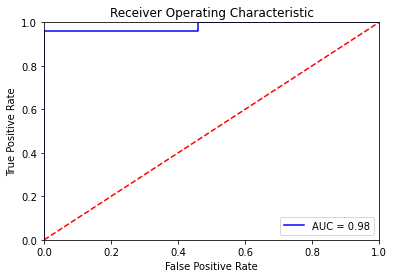

In [22]:
# Compute predicted probabilities on the test set
probs = bert_predict(bert_classifier, val_dataloader)

# Evaluate the Bert classifier
evaluate_roc(probs, y_val_encode)

In [36]:
# Maybe not use
# Concatenate the train set and the validation set
full_train_data = torch.utils.data.ConcatDataset([train_data, val_data])
full_train_sampler = RandomSampler(full_train_data)
full_train_dataloader = DataLoader(full_train_data, sampler=full_train_sampler, batch_size=32)

# Train the Bert Classifier on the entire training data
set_seed(42)
bert_classifier, optimizer, scheduler = initialize_model(epochs=2)
train(bert_classifier, full_train_dataloader, epochs=2)

Start training...

 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
   1    |   20    |   0.395516   |     -      |     -     |   2.92   
   1    |   40    |   0.076552   |     -      |     -     |   2.74   
   1    |   60    |   0.041534   |     -      |     -     |   2.72   
   1    |   80    |   0.056735   |     -      |     -     |   2.75   
   1    |   100   |   0.047529   |     -      |     -     |   2.70   
   1    |   120   |   0.029075   |     -      |     -     |   2.72   
   1    |   140   |   0.017800   |     -      |     -     |   2.71   
   1    |   160   |   0.021259   |     -      |     -     |   2.71   
   1    |   180   |   0.023377   |     -      |     -     |   2.70   
   1    |   200   |   0.035580   |     -      |     -     |   2.69   
   1    |   220   |   0.025894   |     -      |     -     |   2.70   
   1    |   240   |   0.041768   |     -      |     -     |   2.72   


In [23]:
df_test.sample(5)

,Id,Content,Sentiment
179,9.200000e+17,RT @therealMickeyT: Wasn't the performance we ...,Positive
9,9.190000e+17,RT @memetribute: when people ask why your twit...,Negative
281,9.369240e+17,I Want To Die,Negative
284,9.365750e+17,I just have this sick feeling that you would b...,Negative
175,9.200000e+17,sbux is exclusively playing rostam and beck i ...,Positive


In [24]:
# Run `preprocessing_for_bert` on the test set
print('Tokenizing data...')
test_inputs, test_masks = preprocessing_for_bert(df_test['Content'].values)

# Create the DataLoader for our test set
test_dataset = TensorDataset(test_inputs, test_masks)
test_sampler = SequentialSampler(test_dataset)
test_dataloader = DataLoader(test_dataset, sampler=test_sampler, batch_size=32)

Tokenizing data...


/home/psimilan/anaconda3/lib/python3.8/site-packages/transformers/tokenization_utils_base.py:2136: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [25]:
# Compute predicted probabilities on the test set
probs = bert_predict(bert_classifier, test_dataloader)

# Get predictions from the probabilities
threshold = 0.9
preds = np.where(probs[:, 1] > threshold, 1, 0)

# Number of tweets predicted non-negative
print("Number of tweets predicted non-negative: ", preds.sum())

Number of tweets predicted non-negative:  19


In [27]:
from collections import Counter

print("Balanced Checking: ", Counter(df_test['Sentiment']))

Balanced Checking:  Counter({'Negative': 40, 'Positive': 21})


In [28]:
print(probs[:, 1])
print(preds)
print(y_test)

[0.9895695  0.00193594 0.9884644  0.9896241  0.00199475 0.003085
 0.98962396 0.00169207 0.00171212 0.00205175 0.00183084 0.00191619
 0.00169926 0.98957753 0.9897007  0.0017548  0.9896197  0.9892859
 0.02562626 0.0018451  0.9895063  0.00177544 0.0017598  0.00179678
 0.9896395  0.9897383  0.9896521  0.00179985 0.0018732  0.98923117
 0.98951167 0.00180449 0.98971564 0.00365685 0.13033128 0.0670877
 0.00181906 0.00181375 0.00174021 0.03290012 0.00195217 0.00394256
 0.98973536 0.9892657  0.00171866 0.9897204  0.00184281 0.00189986
 0.00176689 0.8771329  0.00170639 0.9896137  0.00172599 0.0065579
 0.01062915 0.00171579 0.00256356 0.00199223 0.00177847 0.38327172
 0.80556005]
[1 0 1 1 0 0 1 0 0 0 0 0 0 1 1 0 1 1 0 0 1 0 0 0 1 1 1 0 0 1 1 0 1 0 0 0 0
 0 0 0 0 0 1 1 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0]
[1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1]


In [29]:
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

accuracy = accuracy_score(y_test, preds)
f1 = f1_score(y_test, preds, average='weighted')
print("Accuracy: %.2f%%" % (accuracy*100))
print("F1 Score: %.2f" % (f1*100))

print(classification_report(y_test, preds))

Accuracy: 96.72%
F1 Score: 96.68
              precision    recall  f1-score   support

           0       0.95      1.00      0.98        40
           1       1.00      0.90      0.95        21

    accuracy                           0.97        61
   macro avg       0.98      0.95      0.96        61
weighted avg       0.97      0.97      0.97        61



In [30]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, preds)

array([[40,  0],
       [ 2, 19]])

In [31]:
import pickle
with open('./model/Fine-Tuning_BERT-Suicide.h5', 'wb') as model:
    pickle.dump(bert_classifier, model)